# MCAO residuals computation

### Getting projection matrices

In [145]:
from apposto.utils.footprint_geometry import FootprintGeometry
from apposto.utils.zernike_projection_on_subaperture import ZernikeProjectionOnSubaperture
import numpy as np
import matplotlib as mpl

In [157]:
z1 = 0
z2 = 10e3
r_tele = 10
zenith_angle = 0
fov = 50
th_target = 0
az_target = 0
th_ngs1 = 30
az_ngs1 = 0
th_ngs2 = -30
az_ngs2 = 0
modes_to_correct = 2
modes_layer1 = 2
modes_layer2 = 3
    
fg = FootprintGeometry()
fg.setTelescopeRadiusInMeter(r_tele)
fg.set_zenith_angle(zenith_angle)
fg.setInstrumentFoV(fov)
fg.addLgs(0,0,0,0)
fg.addNgs(th_ngs1, az_ngs1)
fg.addNgs(th_ngs2, az_ngs2)
fg.addTarget(th_target, az_target)

In [158]:
def getProjectionMatricesForOneLayer(z_layer, n_modes_to_correct, m_modes_for_layer):
    fg.setLayerAltitude(z_layer)
    fg.compute()
    mpl.rcParams['figure.dpi'] = 100
    fg.plot()
    fg.report()
    
    R = fg._metapupilL[0][2]
    h_target = np.sqrt(fg._targetsL[0][0]**2 + fg._targetsL[0][1])
    az_target = np.arctan2(fg._targetsL[0][1], fg._targetsL[0][0])
    zp_target = ZernikeProjectionOnSubaperture(pupilRadiusInMeter=R,
                                               subapsRadiusInMeter=r_tele,
                                               subapOffAxisRadiusInMeter=h_target,
                                               subapOffAxisAzimuthInDegrees=az_target)
    p_on = zp_target.getProjectionMatrix()[:n_modes_to_correct,:m_modes_for_layer]
    
    h_ngs1 = np.sqrt(fg._ngsL[0][0]**2 + fg._ngsL[0][1])
    az_ngs1 = np.arctan2(fg._ngsL[0][1], fg._ngsL[0][0])
    zp_ngs1 = ZernikeProjectionOnSubaperture(pupilRadiusInMeter=R,
                                             subapsRadiusInMeter=r_tele,
                                             subapOffAxisRadiusInMeter=h_ngs1,
                                             subapOffAxisAzimuthInDegrees=az_ngs1)
    p_ngs1 = zp_ngs1.getProjectionMatrix()[:n_modes_to_correct,:m_modes_for_layer]

    h_ngs2 = np.sqrt(fg._ngsL[1][0]**2 + fg._ngsL[1][1])
    az_ngs2 = np.arctan2(fg._ngsL[1][1], fg._ngsL[1][0])
    zp_ngs2 = ZernikeProjectionOnSubaperture(pupilRadiusInMeter=R,
                                             subapsRadiusInMeter=r_tele,
                                             subapOffAxisRadiusInMeter=h_ngs2,
                                             subapOffAxisAzimuthInDegrees=az_ngs2)
    p_ngs2 = zp_ngs2.getProjectionMatrix()[:n_modes_to_correct,:m_modes_for_layer]
    
    p_off = np.vstack((p_ngs1, p_ngs2))
    
    return p_on, p_off

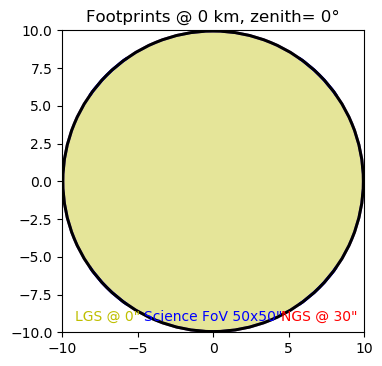

LGS (x,y,r): 0.000000, 0.000000 - 10.000000
NGS (x,y,r): 0.000000, 0.000000 - 10.000000
NGS (x,y,r): -0.000000, -0.000000 - 10.000000
Targets (x,y,r): 0.000000, 0.000000 - 10.000000
Science (x,y,r): 0.000000, 0.000000 - 10.000000
Science (x,y,r): -0.000000, 0.000000 - 10.000000
Science (x,y,r): -0.000000, -0.000000 - 10.000000
Science (x,y,r): 0.000000, -0.000000 - 10.000000
Metapupil (x,y,r): 0.000000, 0.000000 - 10.000000
[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [159]:
p_on_layer1, p_off_layer1 = getProjectionMatricesForOneLayer(z1, modes_to_correct, modes_layer1)

print(p_on_layer1)
print(p_off_layer1)

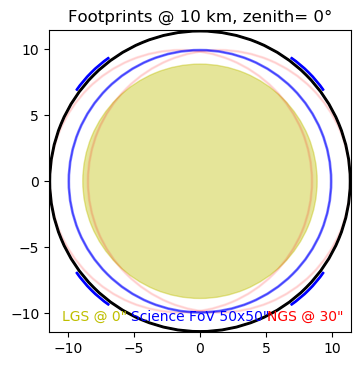

LGS (x,y,r): 0.000000, 0.000000 - 8.888889
NGS (x,y,r): 1.454400, 0.000000 - 10.000000
NGS (x,y,r): -1.454400, -0.000000 - 10.000000
Targets (x,y,r): 0.000000, 0.000000 - 10.000000
Science (x,y,r): 1.212000, 1.212000 - 10.000000
Science (x,y,r): -1.212000, 1.212000 - 10.000000
Science (x,y,r): -1.212000, -1.212000 - 10.000000
Science (x,y,r): 1.212000, -1.212000 - 10.000000
Metapupil (x,y,r): 0.000000, 0.000000 - 11.454400
[[0.87302696 0.         0.        ]
 [0.         0.87302696 0.        ]]
[[0.87302696 0.         0.        ]
 [0.         0.87302696 0.        ]
 [0.87302696 0.         0.        ]
 [0.         0.87302696 0.        ]]


In [160]:
p_on_layer2, p_off_layer2 = getProjectionMatricesForOneLayer(z2, modes_to_correct, modes_layer2)
print(p_on_layer2)
print(p_off_layer2)

In [164]:
# Getting projection matrices on and off axis.
p_on = np.hstack((p_on_layer1, p_on_layer2))
p_off = np.hstack((p_off_layer1, p_off_layer2))

want_on = (modes_to_correct, (modes_layer1 + modes_layer2))
want_off = (modes_to_correct * 2, (modes_layer1 + modes_layer2))
print(p_on.shape)
print(want_on)
print(p_off.shape)
print(want_off)

(2, 5)
(2, 5)
(4, 5)
(4, 5)


In [165]:
# Getting the reconstructor.

w = np.linalg.pinv(p_off)
print(w.shape)

(5, 4)


### Getting CPSDs

In [20]:
from apposto.atmo.von_karman_covariance_calculator import VonKarmanSpatioTemporalCovariance                                                             
from apposto.types.guide_source import GuideSource                                                                                                      
from apposto.types.aperture import CircularOpticalAperture
from apposto.atmo.cn2_profile import EsoEltProfiles
import numpy as np

target = GuideSource((th_target, az_target), np.inf)
ngs1 = GuideSource((th_ngs1, az_ngs1), np.inf)
ngs2 = GuideSource((th_ngs2, az_ngs2), np.inf)
ap = CircularOpticalAperture(5, [0,0,0])
cn2 = EsoEltProfiles.Median()
temp_freqs = np.logspace(-3, 3, 1000)                                                                                                                  
spat_freqs = np.logspace(-3, 3, 1000)

In [21]:
# CPSDs on target
vk = VonKarmanSpatioTemporalCovariance(source1=target, source2=target, aperture1=ap, aperture2=ap,
                                       cn2_profile=cn2, spat_freqs=spat_freqs)

cpsd_on_22 = vk.getGeneralZernikeCPSD(2, 2, temp_freqs)
cpsd_on_23 = vk.getGeneralZernikeCPSD(2, 3, temp_freqs)
cpsd_on_33 = vk.getGeneralZernikeCPSD(3, 3, temp_freqs)

In [173]:
cpsd_on = np.array([[cpsd_on_22, cpsd_on_23], [cpsd_on_23, cpsd_on_33]])
cpsd_on.shape

(2, 2, 1000)

In [24]:
# CPSDs between target and NGS1
vk.setSource2(ngs1)
cpsd_off_22_ngs1 = vk.getGeneralZernikeCPSD(2, 2, temp_freqs)
cpsd_off_23_ngs1 = vk.getGeneralZernikeCPSD(2, 3, temp_freqs)
cpsd_off_33_ngs1 = vk.getGeneralZernikeCPSD(3, 3, temp_freqs)

In [166]:
cpsd_off_1 = np.array([[cpsd_off_22_ngs1, cpsd_off_23_ngs1], [cpsd_off_23_ngs1, cpsd_off_33_ngs1]])

In [25]:
# CPSDs between target and NGS2
vk.setSource2(ngs2)
cpsd_off_22_ngs2 = vk.getGeneralZernikeCPSD(2, 2, temp_freqs)
cpsd_off_23_ngs2 = vk.getGeneralZernikeCPSD(2, 3, temp_freqs)
cpsd_off_33_ngs2 = vk.getGeneralZernikeCPSD(3, 3, temp_freqs)

In [167]:
cpsd_off_2 = np.array([[cpsd_off_22_ngs2, cpsd_off_23_ngs2], [cpsd_off_23_ngs2, cpsd_off_33_ngs2]])

In [169]:
cpsd_off = np.vstack((cpsd_off_1, cpsd_off_2))
cpsd_off.shape

(4, 2, 1000)

In [170]:
cpsd_noise = np.zeros((2, 2, 1000))

### Getting integrator

In [171]:
from apposto.utils.integrator import SimpleIntegrator

d = 3.
g = 0.3
f = temp_freqs
ig = SimpleIntegrator()
ig.setDelay(d)
ig.setGain(g)
ig.setTemporalFrequencies(f)

### Computing MCAO residual

In [174]:
from apposto.utils import residual_calculator

rc = residual_calculator.ResidualCalculator(cpsd_on, cpsd_off, cpsd_noise, ig)

In [177]:
res = rc.getMCAOResidual(p_on, p_off, w, temp_freqs).real
print(res)

[[64.9699998  -3.5784192 ]
 [-3.5784192  71.01913238]]
